Assist - Cycle 1: Final Error = -0.3604, Weights = [1.34504386 3.02375181 0.89854114]
Assist - Cycle 2: Final Error = -0.0413, Weights = [-1.23827949  0.53063138  0.27284118]
Assist - Cycle 3: Final Error = -0.4215, Weights = [ 1.60722917  3.46689541 -1.21557353]
Assist - Cycle 4: Final Error = 0.3627, Weights = [-1.55515245  1.51999892  1.34148456]
Assist - Cycle 5: Final Error = -0.4896, Weights = [ 1.09955393  2.65829773 -2.79166999]
Assist - Cycle 6: Final Error = 0.4773, Weights = [-0.73640547  3.11309161  1.95215743]
Assist - Cycle 7: Final Error = -0.3357, Weights = [-0.32100197  1.18828657 -3.04142845]
Assist - Cycle 8: Final Error = 0.2413, Weights = [0.88627268 4.70397683 1.15324417]
Assist - Cycle 9: Final Error = 0.0935, Weights = [-2.07426984  0.07647434 -1.55255094]
Assist - Cycle 10: Final Error = -0.2464, Weights = [ 2.37536784  5.30220301 -1.15112728]


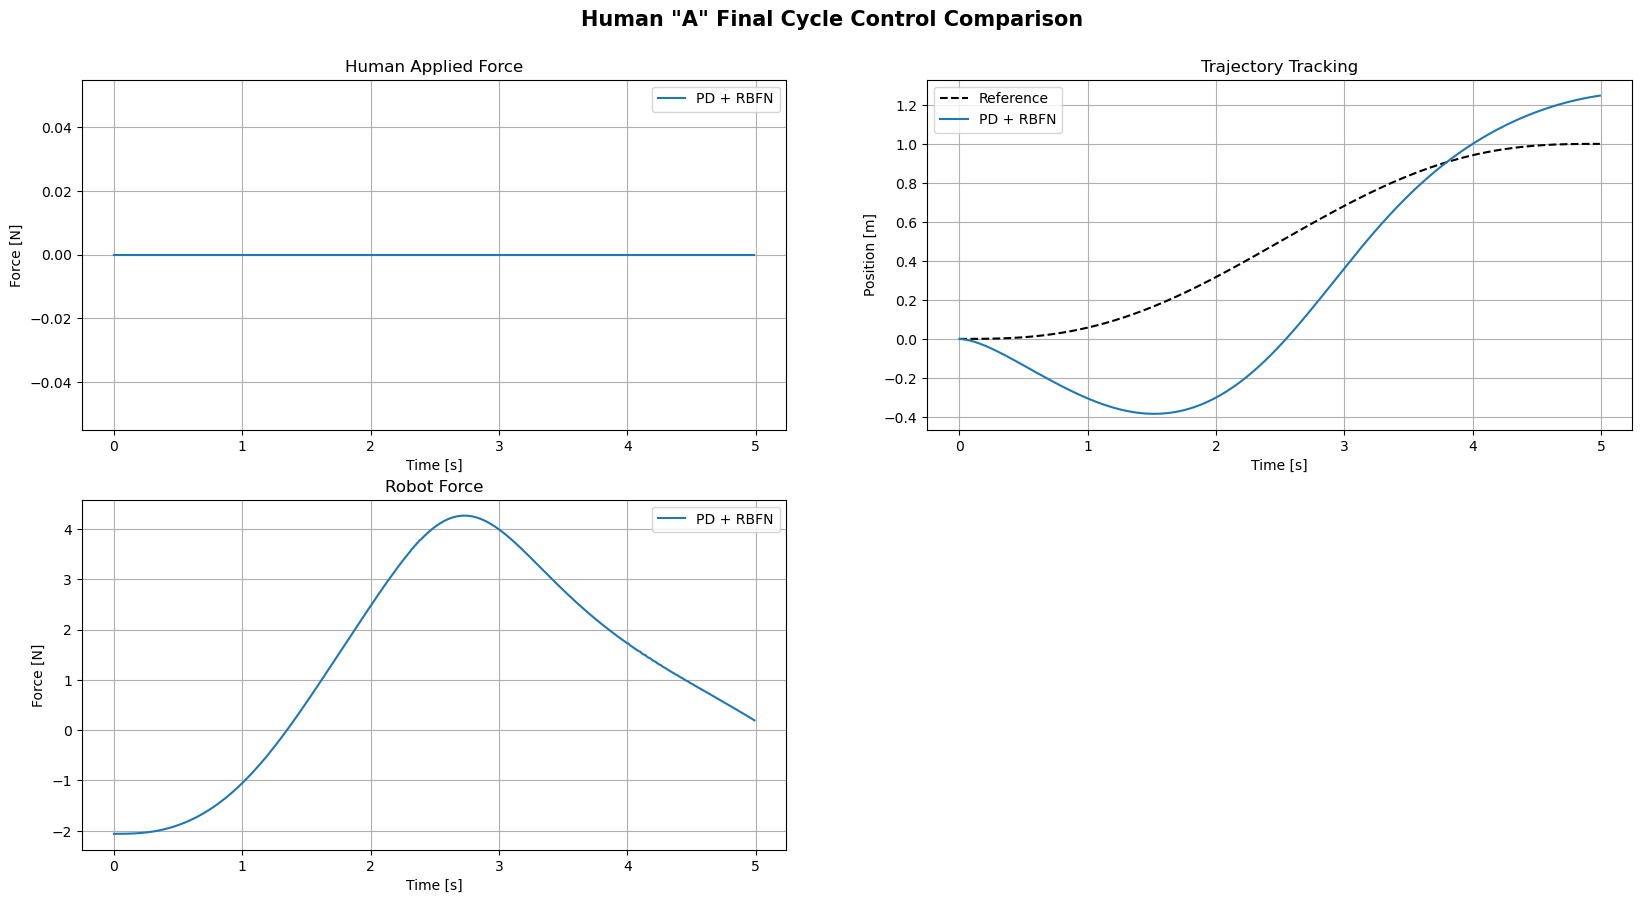

In [5]:
import numpy as np
import matplotlib.pyplot as plt

dt = 0.01             
T_cycle = 5           
n_cycles = 10        

# Minimum Jerk Trajectory
x0, xf = 0.0, 1.0

# PID Controller Parameters
Kp, Ki, Kd = 0, 0, 0

# RBF Network Parameters
n_rbf = 3  
centers = np.linspace(0, 1, n_rbf)  
sigma = 0.3  
eta = 6
forgetting_factor = 1  

# Select Human Force Profile
human_type = "A"  

# System Dynamics Assumptions
m = 1.0
b = 5.0

def get_human_force(t_cycle, x, x_ref, human_type):
    """Compute human force (N) based on different profile types."""
    if human_type == "A":
        return 0
    elif human_type == "B":
        return 10
    elif human_type == "C":
        return 10 * (x_ref - x)
    elif human_type == "D":
        return 50 * (x_ref - x)
    elif human_type == "E":
        return np.clip(50 * (x_ref - x), 0, 1)
    elif human_type == "F":
        return 1 + 1 * np.sin(2 * np.pi * 0.3 * t_cycle)
    elif human_type == "G":
        return 2 * np.sin(2 * np.pi * 0.6 * t_cycle)
    return 0.0

def compute_rbf_outputs(x_val, centers, sigma):
    """Compute Gaussian RBF outputs for a given state."""
    return np.exp(-((x_val - centers)**2) / (2 * sigma**2))

    # Data storage
all_cycle_trajectories = []
all_cycle_refs = []
all_cycle_assist = []
all_cycle_human = []
all_cycle_robot = []
all_cycle_final_error = []
all_cycle_weights = []

# Initialize RBF weights
weights = np.zeros(n_rbf)

for cycle in range(n_cycles):
    t_cycle_vec = np.arange(0, T_cycle, dt)
    tau = t_cycle_vec / T_cycle  
    x_ref_cycle = x0 + (xf - x0) * (10*tau**3 - 15*tau**4 + 6*tau**5)
    all_cycle_refs.append(x_ref_cycle)
    
    x = x0
    x_dot = 0.0
    x_ddot = 0.0

    integral_error = 0.0
    cycle_trajectory, cycle_assist_force, cycle_human_force, cycle_robot_force, cycle_errors = [], [], [], [], []
    
    for t_current in t_cycle_vec:
        i = int(t_current / dt)
        x_ref = x_ref_cycle[i]
        error = x_ref - x

        # PID Controller
        integral_error += error * dt
        u_pid = Kp * error + Ki * integral_error
        
        # RBF-based Assist
        phi = compute_rbf_outputs(x_ref, centers, sigma)
        f_assist = np.dot(weights, phi)
        
        # Human force
        f_human = get_human_force(t_current, x, x_ref, human_type)
        
        # Total control input
        u_total = u_pid + f_assist
        
        # Update state
        # x += dt * (u_total + f_human)
        x_ddot = (u_total + f_human - b * x_dot) / m 
        x_dot += dt * x_ddot  
        x += dt * x_dot  
        
        # Weight update
        lambda_factor = forgetting_factor if cycle >= 5 else 1.0
        weights = lambda_factor * weights + eta * error * phi * dt
        
        # Store data
        cycle_trajectory.append(x)
        cycle_assist_force.append(f_assist)
        cycle_human_force.append(f_human)
        cycle_robot_force.append(u_total)
        cycle_errors.append(error)
    
    # Save cycle data
    all_cycle_trajectories.append(cycle_trajectory)
    all_cycle_assist.append(cycle_assist_force)
    all_cycle_human.append(cycle_human_force)
    all_cycle_robot.append(cycle_robot_force)
    all_cycle_final_error.append(cycle_errors[-1])
    all_cycle_weights.append(weights.copy())
    
    print(f"Assist - Cycle {cycle+1}: Final Error = {cycle_errors[-1]:.4f}, Weights = {weights}")

plt.figure(figsize=(20, 10))
plt.suptitle(f'Human "{human_type}" Final Cycle Control Comparison', fontsize=15, fontweight='bold', y=0.95)

# 1. Human Force Comparison
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, T_cycle, dt), np.array(all_cycle_human[-1]), label='PD + RBFN')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Human Applied Force')
plt.legend()
plt.grid(True)

# 2. Trajectory Tracking (RBFN + PD)
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, T_cycle, dt), np.array(all_cycle_refs[-1]), 'k--', label='Reference')
plt.plot(np.arange(0, T_cycle, dt), np.array(all_cycle_trajectories[-1]), label='PD + RBFN')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Trajectory Tracking')
plt.legend()
plt.grid(True)

# 3. Robot Force Comparison
plt.subplot(2, 2, 3)
plt.plot(np.arange(0, T_cycle, dt), np.array(all_cycle_robot[-1]), label='PD + RBFN')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.title('Robot Force')
plt.legend()
plt.grid(True)



===== Starting Fine-tuning with Combined Loss (Assist and Resist) using Backpropagation =====
Fine-tuning Cycle 1: Final Error = -2.2617, Average Cost = 2.6113
    Assist Weights = [ 2.37536784  5.30220301 -1.15112728], Resist Weights = [0. 0. 0.]


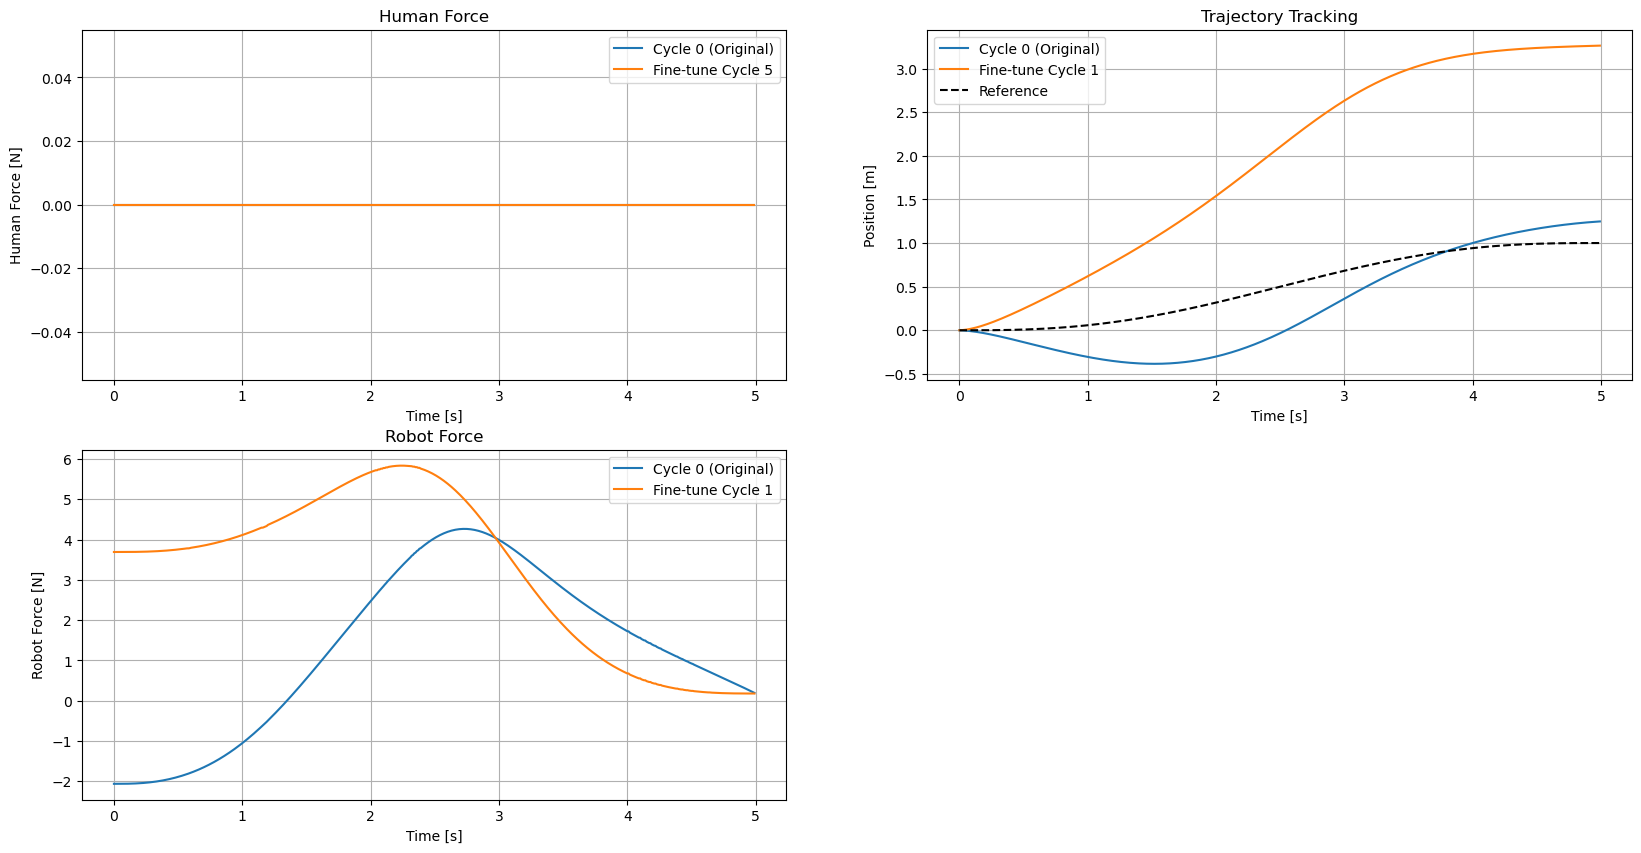

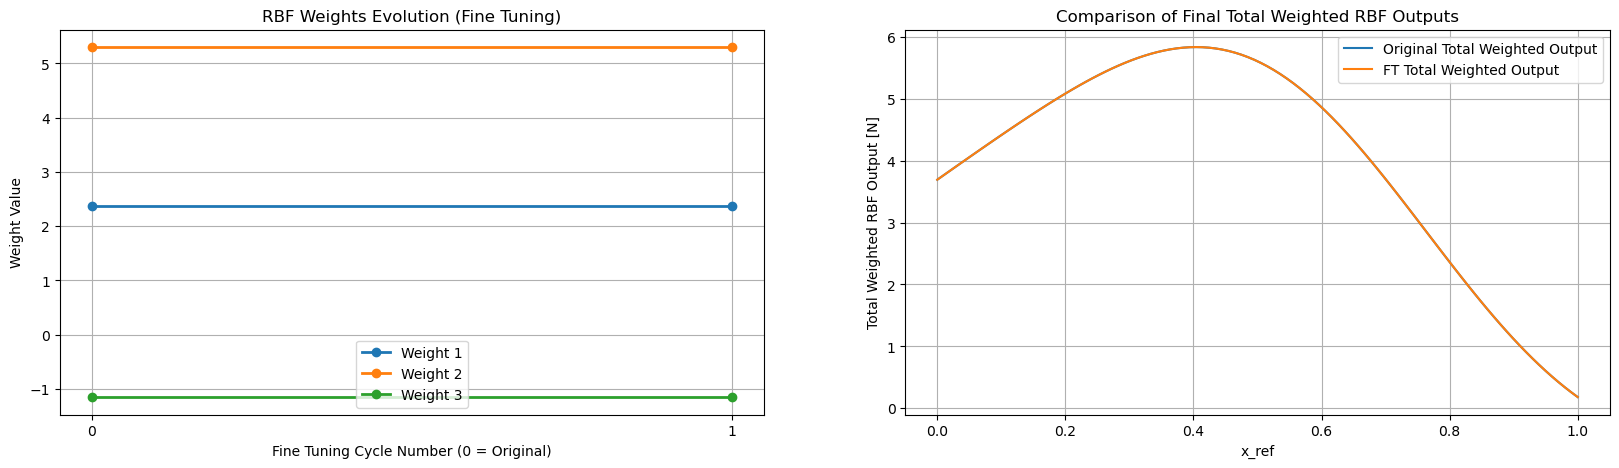

In [6]:
# ===== Fine-tuning with Combined Loss including Resist Term using Gradient Descent with Backpropagation =====
n_finetune = 1           # Number of additional fine-tuning cycles
eta_resist = 0.00        # Learning rate for updating resist weights
gamma_resist = 1         # Not used in this update

# Cost weights (adjust based on context)
W1 = 0.004    # Weight for assist and resist forces
W2 = 1        # Weight for the squared error term

# Assist weights are assumed to have been updated before fine-tuning.
# Initialize new resist weights for fine-tuning.
weights_resist = np.zeros(n_rbf)

# Initialize lists to store fine-tuning results
ft_cycle_trajectories = []   # Trajectories for each fine-tuning cycle
ft_cycle_assist = []         # Assist force for each fine-tuning cycle
ft_cycle_resist = []         # Resist force for each fine-tuning cycle
ft_cycle_robot = []          # Total robot force for each fine-tuning cycle
ft_cycle_human = []          # Human force for each fine-tuning cycle
ft_cycle_weights = []        # Final Assist RBFN weights for each fine-tuning cycle
ft_cycle_resist_weights = [] # Final resist weights for each fine-tuning cycle
ft_cycle_costs = []          # Cost for each fine-tuning cycle


print("\n===== Starting Fine-tuning with Combined Loss (Assist and Resist) using Backpropagation =====")
for ft_cycle in range(n_finetune):
    t_cycle_vec = np.arange(0, T_cycle, dt)
    # x_ref_cycle = all_cycle_refs[-1]   # Use the reference trajectory from the last cycle
    tau = t_cycle_vec / T_cycle  
    x_ref_cycle = x0 + (xf - x0) * (10*tau**3 - 15*tau**4 + 6*tau**5)

    
    x = x0
    x_dot = 0.0
    x_ddot = 0.0

    integral_error = 0.0

    # Initialize lists to store data for the current cycle
    cycle_trajectory_ft = []
    cycle_assist_force = []
    cycle_resist_force = []
    cycle_robot_force = []
    cycle_human_force = []   # List to store human force at each time step
    cycle_cost = []          # Store cost at each time step

    for t_current in t_cycle_vec:
        i = int(t_current / dt)
        x_ref = x_ref_cycle[i]
        error = x_ref - x

        # PID Controller
        integral_error += error * dt
        u_pid = Kp * error + Ki * integral_error

        # RBF-based Assist Force (using pre-trained weights)
        phi = compute_rbf_outputs(x_ref, centers, sigma)
        f_assist = np.dot(all_cycle_weights[-1], phi)
        # print(f_assist)

        # RBF-based Resist Force (using new weights)
        f_resist = np.dot(weights_resist, phi)
        
        # Compute cost: cost = W1*(f_assist + f_resist) + W2*(error^2)
        cost = W1 * (f_assist + f_resist) + W2 * (error ** 2)
        cycle_cost.append(cost)

 

        # Update resist weights using backpropagation
        # f_resist is a linear combination of weights_resist and phi, so:
        #   ∂(W1 * f_resist)/∂weights_resist = W1 * phi
        # Also, since error = x_ref - x and f_resist affects the state update with dt:
        #   ∂(error^2)/∂f_resist = -2 * error * dt
        # Therefore, by applying the chain rule:
        #   ∂(W2 * error^2)/∂weights_resist = -2 * W2 * error * dt * phi
        # Final gradient:
        grad_cost = (W1 - 2 * W2 * error * dt) * phi
        weights_resist = weights_resist - eta_resist * grad_cost

        # State update (including human force)
        f_human = get_human_force(t_current, x, x_ref, human_type)

        # Compute total control input: PID + Assist + Resist
        u_total = u_pid + f_assist #+ f_resist
        # x += dt * (u_total + f_human)
        x_ddot = (u_total + f_human - b * x_dot) / m 
        x_dot += dt * x_ddot  
        x += dt * x_dot  

        # Store data for the current time step
        cycle_trajectory_ft.append(x)
        cycle_assist_force.append(f_assist)
        cycle_resist_force.append(f_resist)
        cycle_robot_force.append(u_total)
        cycle_human_force.append(f_human)

    # Save fine-tuning cycle data
    ft_cycle_trajectories.append(cycle_trajectory_ft)
    ft_cycle_assist.append(cycle_assist_force)
    ft_cycle_resist.append(cycle_resist_force)
    ft_cycle_robot.append(cycle_robot_force)
    ft_cycle_weights.append(weights.copy())
    ft_cycle_resist_weights.append(weights_resist.copy())
    ft_cycle_costs.append(cycle_cost)
    ft_cycle_human.append(cycle_human_force)

    # Compute average cost for the current cycle
    avg_cost = np.mean(cycle_cost)
    # print(f"original_weights: {all_cycle_weights[-1]}")
    print(f"Fine-tuning Cycle {ft_cycle+1}: Final Error = {error:.4f}, Average Cost = {avg_cost:.4f}")
    print(f"    Assist Weights = {weights}, Resist Weights = {weights_resist}")

# Treat the original last cycle as Cycle 0 and append the fine-tuning cycles afterward.
ft_trajectories = [np.array(all_cycle_trajectories[-1])] + [np.array(traj) for traj in ft_cycle_trajectories]
# print(ft_trajectories)
ft_robot = [np.array(all_cycle_robot[-1])] + [np.array(robot) for robot in ft_cycle_robot]
ft_weights = [np.array(all_cycle_weights[-1])] + [np.array(all_cycle_weights[-1]) + np.array(w) for w in ft_cycle_resist_weights]

# ========== Plot Fine Tuning Comparison: Trajectory, Assist, Robot ==========
t = np.arange(0, T_cycle, dt)
plt.figure(figsize=(20, 10))

# Human Force
plt.subplot(2, 2, 1)
plt.plot(t, np.array(all_cycle_human[-1]), label='Cycle 0 (Original)')
plt.plot(t, ft_cycle_human[-1], label='Fine-tune Cycle 5')
plt.xlabel('Time [s]')
plt.ylabel('Human Force [N]')
plt.title('Human Force')
plt.legend()
plt.grid(True)

# Trajectory Tracking
plt.subplot(2, 2, 2)
for idx, traj in enumerate(ft_trajectories):
    label_str = 'Cycle 0 (Original)' if idx == 0 else f'Fine-tune Cycle {idx}'
    plt.plot(t, traj, label=label_str)
plt.plot(t, np.array(all_cycle_refs[-1]), 'k--', label='Reference')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Trajectory Tracking')
plt.legend()
plt.grid(True)

# Robot Force
plt.subplot(2, 2, 3)
for idx, rf in enumerate(ft_robot):
    label_str = 'Cycle 0 (Original)' if idx == 0 else f'Fine-tune Cycle {idx}'
    plt.plot(t, rf, label=label_str)
plt.xlabel('Time [s]')
plt.ylabel('Robot Force [N]')
plt.title('Robot Force')
plt.legend()
plt.grid(True)

# If there is no change in human force during fine tuning, you may only display the original or omit this plot.


# ===================== Plot RBF Weights Evolution during Fine Tuning =====================
# Plot the evolution of the RBF weights over the fine-tuning cycles.
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
# The number of ft_weights is original + the number of fine-tuning cycles (e.g., 1 + 5 = 6)
x_axis = np.arange(len(ft_weights))
ft_weights_arr = np.array(ft_weights)
for i in range(n_rbf):
    plt.plot(x_axis, ft_weights_arr[:, i], marker='o', lw=2, label=f'Weight {i+1}')
plt.xlabel('Fine Tuning Cycle Number (0 = Original)')
plt.ylabel('Weight Value')
plt.title('RBF Weights Evolution (Fine Tuning)')
plt.legend()
plt.grid(True)
plt.xticks(x_axis)

# ===================== Compare Final Total Weighted RBF Outputs =====================
# Generate RBF outputs for a range of x values
x_range = np.linspace(0, 1, 100)
phi_matrix = np.zeros((len(x_range), n_rbf))
for i, x_val in enumerate(x_range):
    phi_matrix[i, :] = compute_rbf_outputs(x_val, centers, sigma)

# Retrieve the original final RBF weights (Cycle 0) and the fine-tuned final weights
original_weights = ft_weights[0]      # Original final RBF weights
ft_weights_final = ft_weights[-1]       # Fine-tuned final RBF weights

# Compute the total weighted RBF output for both sets of weights
original_total_output = np.sum(phi_matrix * original_weights, axis=1)
ft_total_output = np.sum(phi_matrix * ft_weights_final, axis=1)

plt.subplot(1, 2, 2)
# Plot the comparison of the final total weighted RBF outputs
plt.plot(x_range, original_total_output, label='Original Total Weighted Output')
plt.plot(x_range, ft_total_output,  label='FT Total Weighted Output')
plt.xlabel('x_ref')
plt.ylabel('Total Weighted RBF Output [N]')
plt.title('Comparison of Final Total Weighted RBF Outputs')
plt.legend()
plt.grid(True)

plt.show()


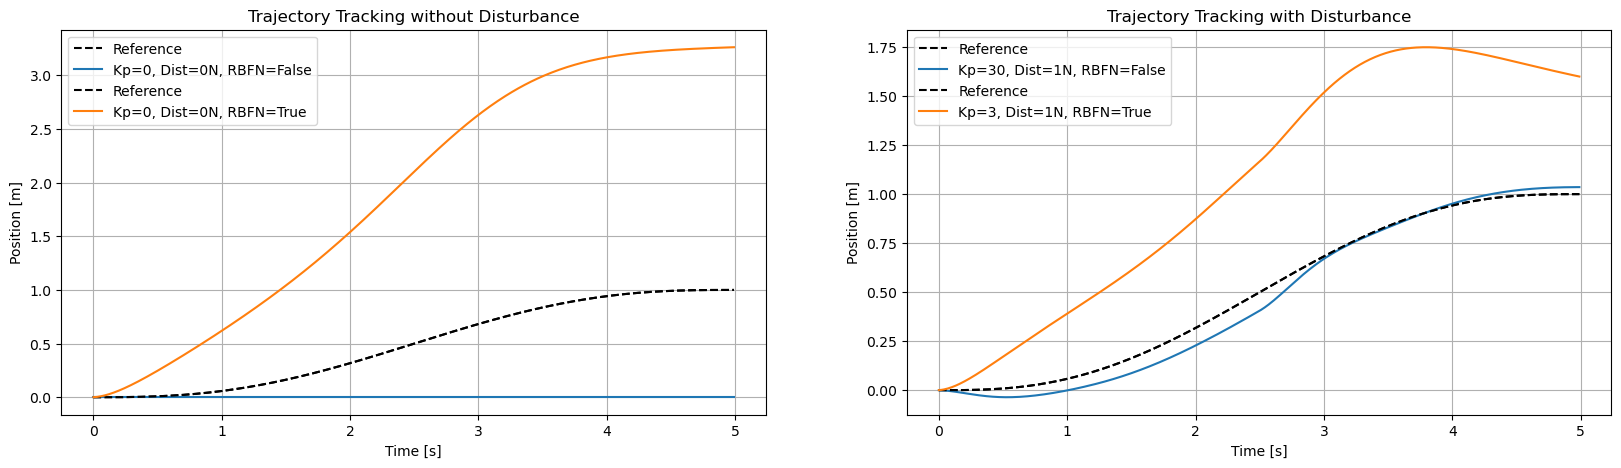

In [8]:
def simulate_trajectory(Kp, dist_amp, use_rbf, switch_time=2.5):
    t_cycle_vec = np.arange(0, T_cycle, dt)
    tau = t_cycle_vec / T_cycle  
    x_ref_cycle = x0 + (xf - x0) * (10*tau**3 - 15*tau**4 + 6*tau**5)
    
    x = x0
    x_dot = 0.0
    x_ddot = 0.0
    integral_error = 0.0
    
    cycle_trajectory, cycle_assist_force, cycle_human_force, cycle_robot_force, cycle_errors = [], [], [], [], []
    
    
    for t_current in t_cycle_vec:
        i = int(t_current / dt)
        x_ref = x_ref_cycle[i]
        error = x_ref - x
    
        # PID Controller
        integral_error += error * dt
        u_pid = Kp * error + Ki * integral_error
    
        # RBF-based Assist (if enabled)
        f_assist = 0.0
        if use_rbf:
            phi = compute_rbf_outputs(x_ref, centers, sigma)
            f_assist = np.dot(all_cycle_weights[-1], phi)
            # print(f_assist)
    
        # Human force model
        f_human = get_human_force(t_current, x, x_ref, "A")
    
        # Disturbance force
        f_dist = dist_amp if t_current > switch_time else -dist_amp
    
        # Total control input
        u_total = u_pid + f_assist + f_dist
    
        # Update state
        x_ddot = (u_total + f_human - b * x_dot) / m 
        x_dot += dt * x_ddot  
        x += dt * x_dot  
    
        # Store data
        cycle_trajectory.append(x)
        cycle_assist_force.append(f_assist)
        cycle_human_force.append(f_human)
        cycle_robot_force.append(u_total)
        cycle_errors.append(error)
    
    # Plot results
    plt.plot(t_cycle_vec, x_ref_cycle, 'k--', label='Reference')
    plt.plot(t_cycle_vec, cycle_trajectory, label=f'Kp={Kp}, Dist={dist_amp}N, RBFN={use_rbf}')
    plt.xlabel('Time [s]')
    plt.ylabel('Position [m]')
    plt.legend()
    plt.grid(True)
   

plt.figure(figsize=(20, 5))

# Simulate Trajectory Tracking without Disturbance
'''Be aware that the human model is set to "A"'''
plt.subplot(1, 2, 1)
simulate_trajectory(Kp=0, dist_amp=0, use_rbf=False)
simulate_trajectory(Kp=0, dist_amp=0, use_rbf=True)
plt.title('Trajectory Tracking without Disturbance')

# Simulate Trajectory Tracking with Disturbance
plt.subplot(1, 2, 2)
simulate_trajectory(Kp=30, dist_amp=1, use_rbf=False)
simulate_trajectory(Kp=3, dist_amp=1, use_rbf=True)
plt.title('Trajectory Tracking with Disturbance')
plt.show()
